# First Team Task (Permutated MNIST)
## Loïc Rosset, Nanae Aubry, Kilian Ruchti, Lionel Ieri

### Import Libraries

In [1]:
# Import module
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid

from copy import deepcopy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from model_task2c import PR_CNN

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier

### Load dataset

In [2]:
# load data
TRAIN_DATASET = "../dataset/mnist-permutated-png-format/mnist/train"
VALIDATION_DATASET = "../dataset/mnist-permutated-png-format/mnist/val"
TEST_DATASET = "../dataset/mnist-permutated-png-format/mnist/test"

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.ImageFolder(root=TRAIN_DATASET, transform=transform)
val_dataset = datasets.ImageFolder(root=VALIDATION_DATASET, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DATASET, transform=transform)

params = {'batch_size': 64, 'shuffle': True}

train_loader = torch.utils.data.DataLoader(train_dataset, **params)
val_loader = torch.utils.data.DataLoader(val_dataset, **params)
test_loader = torch.utils.data.DataLoader(test_dataset, **params)

### Study dataset

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('images shape on PyTroch : ', images.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([64, 3, 28, 28])
labels shape on PyTroch :  torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 151.5, 151.5, -0.5)

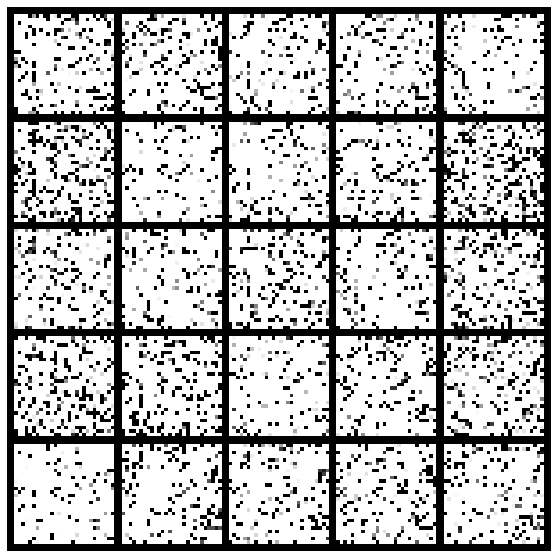

In [4]:
grid = make_grid(images[:25], nrow=5)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off')

### Define Functions

In [5]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

In [6]:
class Training():
    
    def __init__(self, nb_epochs=20, device=torch.device('cpu')):
        self.nb_epochs = nb_epochs
        self.device = device
    
    def train(self, model, train_loader, optimizer, loss_func):
        model.train()
        
        losses = []
        correct_train_pred = 0
        
        for data, labels in train_loader:
            data = data.to(self.device)
            labels = labels.to(self.device)
            
            # Predict the classes of the model
            output = model(data)
        
            optimizer.zero_grad()
            
            # Compute the loss
            loss = loss_func(output, labels)
            
            # Perform backprop
            loss.backward()
            optimizer.step()
            
            # Save current loss
            losses.append(loss.item())
            
            # Save the number of correct classified items
            predicted_labels = output.argmax(dim=1)
            nb_correct = (predicted_labels == labels).sum().item()
            correct_train_pred += nb_correct
    
        train_accuracy = 100. * (correct_train_pred / len(train_loader.dataset))
        
        return np.mean(np.array(losses)), train_accuracy
    
    def validation(self, model, val_loader, loss_func):
        model.eval()
        
        losses = []
        correct_val_predictions = 0
        
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(self.device)
                labels = labels.to(self.device)
                
                output = model(data)
                
                loss = loss_func(output, labels)
                
                # Save current loss
                losses.append(loss.item())
    
                # Save the number of correct classified items
                predicted_labels = output.argmax(dim=1)
                n_correct = (predicted_labels == labels).sum().item()
                correct_val_predictions += n_correct
                
        val_accuracy = 100. * (correct_val_predictions / len(val_loader.dataset))
                
        return np.mean(np.array(losses)), val_accuracy

    def _print_info(self, train_loss, val_loss, train_acc, val_acc):
        print(f'Train_loss: {train_loss:.3f} |\
                Val_loss: {val_loss:.3f} |\
                Train_acc: {train_acc:.3f} |\
                Val_acc: {val_acc:.3f}')

    def fit(self, model, train_loader, val_loader, optimizer, loss_func):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(self.nb_epochs):
            train_loss, train_acc = self.train(model, train_loader, optimizer, loss_func)
            val_loss, val_acc = self.validation(model, val_loader, loss_func)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

        self._print_info(train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1])

        return train_losses, val_losses, train_accuracies, val_accuracies

## 1) CNN

learning rate: 0.001
Train_loss: 0.587 |                Val_loss: 0.555 |                Train_acc: 85.338 |                Val_acc: 85.793
learning rate: 0.01
Train_loss: 0.307 |                Val_loss: 0.323 |                Train_acc: 91.007 |                Val_acc: 90.722
learning rate: 0.1
Train_loss: 0.149 |                Val_loss: 0.174 |                Train_acc: 95.527 |                Val_acc: 94.955


Best parameters: 0.1 learning_rate and validation accuracies: 94.95%


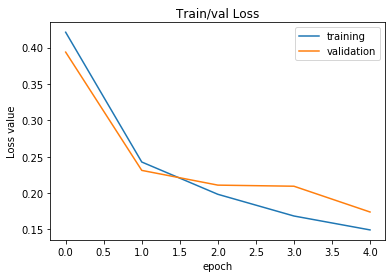

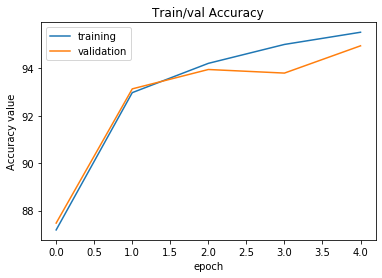

In [7]:
l_rate_set = [0.001, 0.01, 0.1]
nb_epochs = 5
trainer = Training(nb_epochs)

# best parameters: (validation acc, learning rate)
best_parameters = (float("-INF"), None, None)

# keep a copy of the best trained network
best_model = None

loss_function = nn.CrossEntropyLoss()

for l_rate in l_rate_set:
    cnn = PR_CNN()
    optimizer = torch.optim.SGD(cnn.parameters(), l_rate)
    
    # The training take place here :
    print(f'learning rate: {l_rate}')
    stats_training = trainer.fit(cnn, train_loader, val_loader, optimizer, loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], l_rate, stats_training)
        best_model = deepcopy(cnn)

best_acc, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

### Accuracy and Loss

In [8]:
cnn_loss_test, cnn_acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {cnn_acc_test:.2f}%')

Accuracy on the test dataset 94.87%


## 2) MLP

In [9]:
# There is 3 filters!

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2352, 300),
            nn.ReLU(),
            nn.Linear(300, 30)
        )
        
    def forward(self, x):
        # Flatten the images
        x = x.view(x.size(0), -1)
        # Create the layer
        x = self.layers(x)
        return x

learning rate: 0.001
Train_loss: 0.098 |                Val_loss: 0.129 |                Train_acc: 96.910 |                Val_acc: 96.207
learning rate: 0.01
Train_loss: 0.359 |                Val_loss: 0.377 |                Train_acc: 90.087 |                Val_acc: 90.540
learning rate: 0.1
Train_loss: 2.309 |                Val_loss: 2.311 |                Train_acc: 9.948 |                Val_acc: 9.621


Best parameters: 0.001 learning_rate and validation accuracies: 96.21%


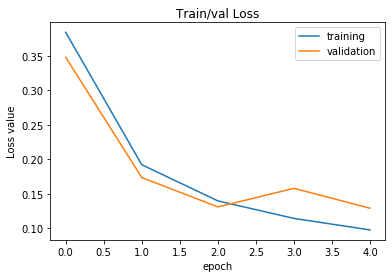

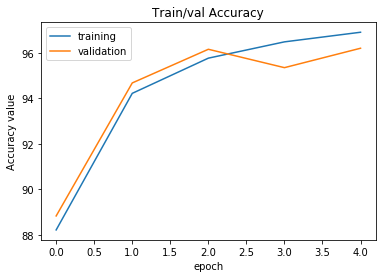

In [10]:
# Initial data
l_rate_set = [0.001, 0.01, 0.1]
nb_epochs = 5
loss_function = nn.CrossEntropyLoss()

trainer = Training(nb_epochs)

# best parameters: (validation acc, learning rate)
best_parameters = (float("-INF"), None, None)

# keep a copy of the best trained network
best_model = None

for l_rate in l_rate_set:
    mlp = MLP()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=l_rate)
    
    # The training take place here :
    print(f'learning rate: {l_rate}')
    stats_training = trainer.fit(mlp, train_loader, val_loader, optimizer, loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], l_rate, stats_training)
        best_model = deepcopy(mlp)

best_acc, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

### Accuracy and Loss

In [11]:
mlp_loss_test, mlp_acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {mlp_acc_test:.2f}%')

Accuracy on the test dataset 96.57%
